In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('./utils')  # or use full path if needed

from trend_regime_utils import load_trend_data, process_trend_data, create_advanced_feat, mayority_vote_cluster_smooth

import pandas as pd
import numpy as np
from datetime import datetime
from zoneinfo import ZoneInfo
import joblib

# For API Keys
import os
from dotenv import load_dotenv
# Alpaca API keys
API_KEY = None
SECRET_KEY = None

load_dotenv(override=True)

if API_KEY is None:
    API_KEY = os.environ.get('ALP_API_KEY')

if SECRET_KEY is None:
    SECRET_KEY = os.environ.get('ALP_SEC_KEY')

In [2]:
EARLIEST_DATE = datetime(2016, 1, 16, tzinfo=ZoneInfo('America/New_York'))
LAST_DATE = datetime(2025, 7, 20, tzinfo=ZoneInfo('America/New_York'))

df_trend_raw = load_trend_data(API_KEY, SECRET_KEY, EARLIEST_DATE, LAST_DATE)

df_trend_processed = process_trend_data(df_trend_raw)

df_trend_feat = create_advanced_feat(df_trend_processed)

c:\Users\sergi\Documents\TFG\utils\trend_regime_utils.py:94: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_feat = df_subset.groupby('symbol').apply(compute_trend_features)
c:\Users\sergi\Documents\TFG\utils\trend_regime_utils.py:94: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_feat = df_subset.groupby('symbol').apply(compute_trend_features)
c:\Users\sergi\Documents\TFG\utils\trend_regime_utils.py:94: FutureWar

In [3]:
MODEL_DIR = "models"
os.makedirs(MODEL_DIR, exist_ok=True)

## If want to predict
# Load models
scaler = joblib.load(os.path.join(MODEL_DIR, "trend_scaler.pkl"))
umap_model = joblib.load(os.path.join(MODEL_DIR, "trend_umap_model.pkl"))
gmm_model = joblib.load(os.path.join(MODEL_DIR, "trend_gmm_model.pkl"))

# scale data
trend_scaled = scaler.transform(df_trend_feat)

# Apply UMAP transformation
trend_umap = umap_model.transform(trend_scaled)

# Predict clusters
trend_gmm_labels = gmm_model.predict(trend_umap)

# from sklearn.metrics import silhouette_score
# print(silhouette_score(trend_umap, trend_gmm_labels))

df_with_clusters = pd.DataFrame(trend_gmm_labels, columns=["cluster"], index=df_trend_feat.index)

df_cluster_smooth = mayority_vote_cluster_smooth(df_with_clusters)

In [4]:
# PCA + Spectral
# UMAP + HDBSCAN

In [5]:
bull_tickers = ['SPY', 'TLT', 'GLD', 'VIXM', 'SPHB', 'SPLV']
df_bull_raw = load_trend_data(API_KEY, SECRET_KEY, EARLIEST_DATE, LAST_DATE, all_tickers=bull_tickers)

print(df_bull_raw.pivot(columns='symbol').isna().sum())

             symbol
open         GLD       0
             SPHB      0
             SPLV      0
             SPY       0
             TLT       0
             VIXM      0
high         GLD       0
             SPHB      0
             SPLV      0
             SPY       0
             TLT       0
             VIXM      0
low          GLD       0
             SPHB      0
             SPLV      0
             SPY       0
             TLT       0
             VIXM      0
close        GLD       0
             SPHB      0
             SPLV      0
             SPY       0
             TLT       0
             VIXM      0
volume       GLD       0
             SPHB      0
             SPLV      0
             SPY       0
             TLT       0
             VIXM      0
trade_count  GLD       0
             SPHB      0
             SPLV      0
             SPY       0
             TLT       0
             VIXM      0
vwap         GLD       0
             SPHB      0
             SPLV      0
     

In [6]:
# --- Configuration ---
ROLLING_WINDOW = 20  # You can adjust this

# --- Filter SPY Data ---
df_spy = df_bull_raw[df_bull_raw['symbol'] == 'SPY'].sort_index().copy()

# --- Feature 1: Trend Consistency Score ---
df_spy['trend_consistency'] = ((df_spy['close'] - df_spy['low']) / 
                                (df_spy['high'] - df_spy['low'] + 1e-6)).rolling(ROLLING_WINDOW).mean()

# --- Feature 2: Volatility Asymmetry Index ---
returns = df_spy['close'].pct_change()

def upside_vol_func(returns_window):
    pos_returns = returns_window[returns_window > 0]
    if len(pos_returns) >= 2:  # needs at least 2 points for std
        return pos_returns.std()
    else:
        return np.nan

upside_vol = returns.rolling(ROLLING_WINDOW).apply(upside_vol_func, raw=False)
total_vol = returns.rolling(ROLLING_WINDOW).std()
df_spy['vol_asymmetry'] = upside_vol / (total_vol + 1e-6)

# --- Feature 6: Higher High Consistency ---
higher_high = (df_spy['high'] > df_spy['high'].shift(1)).astype(int)
df_spy['higher_high_consistency'] = higher_high.rolling(ROLLING_WINDOW).mean()

# --- Feature 8: Volume Trend Divergence ---
df_spy['volume_trend_divergence'] = (
    df_spy['close'].pct_change().rolling(ROLLING_WINDOW)
    .corr(df_spy['volume'].rolling(ROLLING_WINDOW).mean())
)


In [7]:
# --- Helper function to extract close price of a symbol ---
def get_close(symbol):
    return df_bull_raw[df_bull_raw['symbol'] == symbol].sort_index()['close']

# Get closes for external tickers
tlt = get_close('TLT')
gld = get_close('GLD')
vixm = get_close('VIXM')
sphb = get_close('SPHB')
splv = get_close('SPLV')

# Align all external data to SPY's index
external_df = pd.DataFrame(index=df_spy.index)

# --- Feature 7: Correlations ---
external_df['spy_tlt_corr'] = df_spy['close'].pct_change().rolling(ROLLING_WINDOW).corr(tlt.pct_change())
external_df['spy_gld_corr'] = df_spy['close'].pct_change().rolling(ROLLING_WINDOW).corr(gld.pct_change())

# --- Feature 9: Implied Volatility Drift (from VIXM) ---
external_df['vixm_drift'] = vixm.pct_change().rolling(ROLLING_WINDOW).mean()

# --- Feature 10: High Beta vs. Low Volatility Spread ---
external_df['beta_vol_spread'] = sphb.pct_change().rolling(ROLLING_WINDOW).mean() - \
                                  splv.pct_change().rolling(ROLLING_WINDOW).mean()

In [8]:
# Combine SPY-only features and external features
bull_features_df = pd.concat([df_spy[['trend_consistency', 'vol_asymmetry', 
                                 'higher_high_consistency', 'volume_trend_divergence']],
                         external_df], axis=1)

# Optional: Drop rows with missing values
print(bull_features_df.isna().sum())
bull_features_df.dropna(inplace=True)

trend_consistency          19
vol_asymmetry              20
higher_high_consistency    19
volume_trend_divergence    38
spy_tlt_corr               20
spy_gld_corr               20
vixm_drift                 20
beta_vol_spread            20
dtype: int64


In [9]:
# import pandas as pd
# import numpy as np
# from itertools import combinations
# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA
# from sklearn.cluster import SpectralClustering
# from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
# from tqdm import tqdm

# # Configuration space
# n_pca_comps = [2, 3, 4, 5, 6, 7]
# n_clusters_list = [2, 3]
# affinities = ['rbf', 'nearest_neighbors']
# n_neighbors_list = [5, 10, 15]
# assign_labels_list = ['kmeans', 'discretize']
# normalize_options = [True, False]
# kmeans_n_init_list = [10]  # fixed default, no grid search here
# whiten_options = [False]   # fixed, no grid search
# random_states = [3, 7, 11]

# # Subset feature configs
# min_features = 4
# all_columns = list(only_bull_features_df.columns)
# column_subsets = []
# for r in range(min_features, len(all_columns) + 1):
#     column_subsets.extend(combinations(all_columns, r))

# # Store results
# results = []

# # Begin grid search

# for col_subset in tqdm(column_subsets, desc="Feature subset loop"):
#     df_subset = only_bull_features_df[list(col_subset)]

#     for normalize in normalize_options:
#         X = df_subset.values
#         if normalize:
#             X = StandardScaler().fit_transform(X)

#         for pca_comp in n_pca_comps:
#             if pca_comp >= X.shape[1]:
#                 continue
#             pca = PCA(n_components=pca_comp, whiten=False)  # fixed no whitening
#             X_pca = pca.fit_transform(X)

#             for n_clusters in n_clusters_list:
#                 for affinity in affinities:
#                     for assign_labels in assign_labels_list:
#                         for rand in random_states:
#                             if assign_labels == 'kmeans':
#                                 kmeans_n_init = 10  # fixed default
#                                 if affinity == 'rbf':
#                                     model = SpectralClustering(
#                                         n_clusters=n_clusters,
#                                         affinity='rbf',
#                                         assign_labels='kmeans',
#                                         n_init=kmeans_n_init,
#                                         random_state=rand
#                                     )
#                                     # rest unchanged...

#                                     labels = model.fit_predict(X_pca)
#                                     sil = silhouette_score(X_pca, labels)
#                                     ch = calinski_harabasz_score(X_pca, labels)
#                                     db = davies_bouldin_score(X_pca, labels)
#                                     results.append({
#                                         'features_used': col_subset,
#                                         'n_features': len(col_subset),
#                                         'normalize': normalize,
#                                         'whiten': whiten,
#                                         'n_pca_comp': pca_comp,
#                                         'n_clusters': n_clusters,
#                                         'affinity': affinity,
#                                         'assign_labels': assign_labels,
#                                         'n_neighbors': None,
#                                         'kmeans_n_init': kmeans_n_init,
#                                         'random_state': rand,
#                                         'silhouette': sil,
#                                         'calinski_harabasz': ch,
#                                         'davies_bouldin': db
#                                     })
#                                 else:
#                                     for n_neighbors in n_neighbors_list:
#                                         model = SpectralClustering(
#                                             n_clusters=n_clusters,
#                                             affinity='nearest_neighbors',
#                                             n_neighbors=n_neighbors,
#                                             assign_labels='kmeans',
#                                             n_init=kmeans_n_init,
#                                             random_state=rand
#                                         )
#                                         labels = model.fit_predict(X_pca)
#                                         sil = silhouette_score(X_pca, labels)
#                                         ch = calinski_harabasz_score(X_pca, labels)
#                                         db = davies_bouldin_score(X_pca, labels)
#                                         results.append({
#                                             'features_used': col_subset,
#                                             'n_features': len(col_subset),
#                                             'normalize': normalize,
#                                             'whiten': whiten,
#                                             'n_pca_comp': pca_comp,
#                                             'n_clusters': n_clusters,
#                                             'affinity': affinity,
#                                             'assign_labels': assign_labels,
#                                             'n_neighbors': n_neighbors,
#                                             'kmeans_n_init': kmeans_n_init,
#                                             'random_state': rand,
#                                             'silhouette': sil,
#                                             'calinski_harabasz': ch,
#                                             'davies_bouldin': db
#                                         })

#                         else:  # assign_labels == 'discretize'
#                             if affinity == 'rbf':
#                                 model = SpectralClustering(
#                                     n_clusters=n_clusters,
#                                     affinity='rbf',
#                                     assign_labels='discretize',
#                                     random_state=rand
#                                 )
#                                 labels = model.fit_predict(X_pca)
#                                 sil = silhouette_score(X_pca, labels)
#                                 ch = calinski_harabasz_score(X_pca, labels)
#                                 db = davies_bouldin_score(X_pca, labels)
#                                 results.append({
#                                     'features_used': col_subset,
#                                     'n_features': len(col_subset),
#                                     'normalize': normalize,
#                                     'whiten': whiten,
#                                     'n_pca_comp': pca_comp,
#                                     'n_clusters': n_clusters,
#                                     'affinity': affinity,
#                                     'assign_labels': assign_labels,
#                                     'n_neighbors': None,
#                                     'kmeans_n_init': None,
#                                     'random_state': rand,
#                                     'silhouette': sil,
#                                     'calinski_harabasz': ch,
#                                     'davies_bouldin': db
#                                 })
#                             else:
#                                 for n_neighbors in n_neighbors_list:
#                                     model = SpectralClustering(
#                                         n_clusters=n_clusters,
#                                         affinity='nearest_neighbors',
#                                         n_neighbors=n_neighbors,
#                                         assign_labels='discretize',
#                                         random_state=rand
#                                     )
#                                     labels = model.fit_predict(X_pca)
#                                     sil = silhouette_score(X_pca, labels)
#                                     ch = calinski_harabasz_score(X_pca, labels)
#                                     db = davies_bouldin_score(X_pca, labels)
#                                     results.append({
#                                         'features_used': col_subset,
#                                         'n_features': len(col_subset),
#                                         'normalize': normalize,
#                                         'whiten': whiten,
#                                         'n_pca_comp': pca_comp,
#                                         'n_clusters': n_clusters,
#                                         'affinity': affinity,
#                                         'assign_labels': assign_labels,
#                                         'n_neighbors': n_neighbors,
#                                         'kmeans_n_init': None,
#                                         'random_state': rand,
#                                         'silhouette': sil,
#                                         'calinski_harabasz': ch,
#                                         'davies_bouldin': db
#                                     })

# # Final result DataFrame
# grid_df = pd.DataFrame(results) #1h42min

# grid_df.to_csv("bull_spectral_search.csv")

In [13]:
# Ensure full output is shown
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_colwidth', None) # Show full column content
pd.set_option('display.width', 0)           # Prevent line wrapping

# Load and sort the DataFrame
grid_df = pd.read_csv("bull_spectral_search.csv")
sorted_df = grid_df.sort_values(by='silhouette', ascending=False)\
    .reset_index(drop=True)

# Get the first occurrence (lowest index) of each unique 'features_used'
lowest_indices = sorted_df.groupby('features_used', sort=False).apply(lambda x: x.index.min())

# Convert to a DataFrame for display
lowest_indices_df = lowest_indices.reset_index(name='lowest_index')
print("Índices más bajos por grupo de 'features_used':")
print(lowest_indices_df)

# Get the full rows corresponding to those indices
best_rows_df = sorted_df.loc[lowest_indices]
print("\nFilas completas correspondientes al mejor de cada grupo:")
print(best_rows_df)


Índices más bajos por grupo de 'features_used':
                                                                                                  features_used  \
0                                        ('trend_consistency', 'spy_tlt_corr', 'vixm_drift', 'beta_vol_spread')   
1                               ('vol_asymmetry', 'volume_trend_divergence', 'spy_tlt_corr', 'beta_vol_spread')   
2                                        ('trend_consistency', 'spy_gld_corr', 'vixm_drift', 'beta_vol_spread')   
3                                  ('higher_high_consistency', 'spy_tlt_corr', 'vixm_drift', 'beta_vol_spread')   
4             ('trend_consistency', 'higher_high_consistency', 'spy_tlt_corr', 'vixm_drift', 'beta_vol_spread')   
..                                                                                                          ...   
158  ('trend_consistency', 'vol_asymmetry', 'higher_high_consistency', 'volume_trend_divergence', 'vixm_drift')   
159          ('trend_consistency

C:\Users\sergi\AppData\Local\Temp\ipykernel_18100\2790763058.py:12: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  lowest_indices = sorted_df.groupby('features_used', sort=False).apply(lambda x: x.index.min())


Silhouette Score: 0.413
Calinski-Harabasz Score: 250.656
Davies-Bouldin Score: 0.704


IndexError: index 2 is out of bounds for axis 1 with size 2

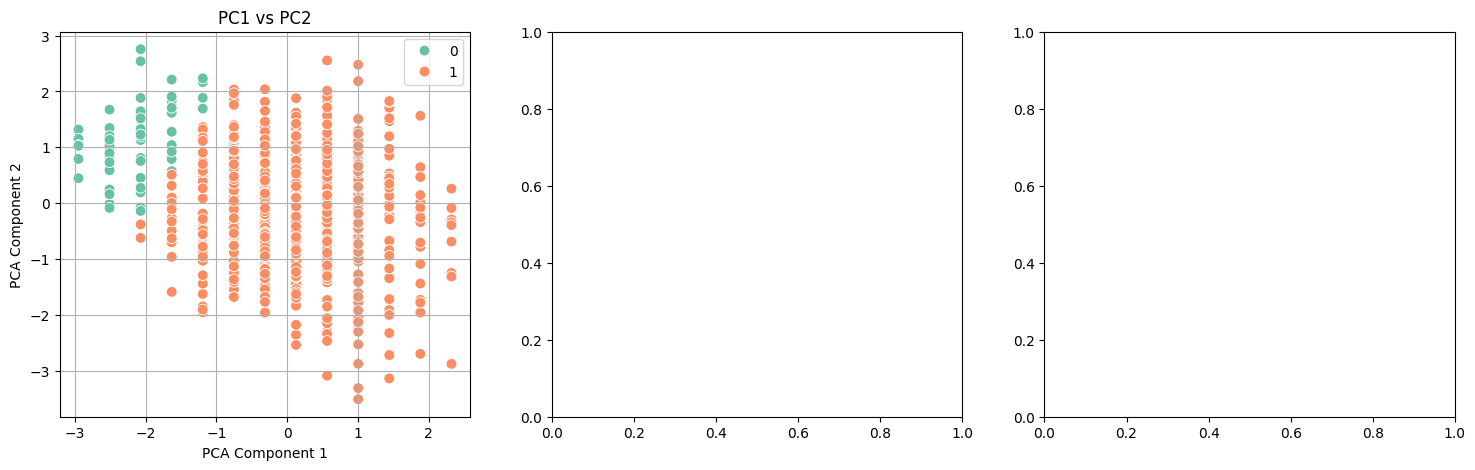

In [25]:
selected_features = ['higher_high_consistency', 'volume_trend_divergence']#, 'vixm_drift', 'beta_vol_spread']

# keep only bull days 
bull_days = df_cluster_smooth[df_cluster_smooth==1]

# Keep only rows in bull_features_df where the index exists in bull_days
only_bull_features_df = bull_features_df[bull_features_df.index.isin(bull_days.index)]

only_bull_features_df = only_bull_features_df[selected_features]

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
# Begin grid search


X = StandardScaler().fit_transform(only_bull_features_df.values)

# pca = PCA(n_components=3, whiten=False)  # fixed no whitening
# X_pca = pca.fit_transform(X)
X_pca = X.copy()
model = SpectralClustering(
    n_clusters=2,
    affinity='rbf',
    #n_neighbors=10,
    assign_labels='kmeans',
    #n_init=10,
    random_state=4
)

labels = model.fit_predict(X_pca)
sil = silhouette_score(X_pca, labels)
ch = calinski_harabasz_score(X_pca, labels)
db = davies_bouldin_score(X_pca, labels)

import matplotlib.pyplot as plt
import seaborn as sns

# 1️⃣ Print clustering scores
print(f"Silhouette Score: {sil:.3f}")
print(f"Calinski-Harabasz Score: {ch:.3f}")
print(f"Davies-Bouldin Score: {db:.3f}")

# 2️⃣ Print PCA explained variance
#print(f"Explained Variance: {pca.explained_variance_ratio_.sum():.3f}")

# Create a row of subplots for PCA component pairs
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# PC1 vs PC2
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels, palette='Set2', s=60, ax=axes[0])
axes[0].set_title("PC1 vs PC2")
axes[0].set_xlabel("PCA Component 1")
axes[0].set_ylabel("PCA Component 2")
axes[0].grid(True)

# PC1 vs PC3
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 2], hue=labels, palette='Set2', s=60, ax=axes[1])
axes[1].set_title("PC1 vs PC3")
axes[1].set_xlabel("PCA Component 1")
axes[1].set_ylabel("PCA Component 3")
axes[1].grid(True)

# PC2 vs PC3
sns.scatterplot(x=X_pca[:, 1], y=X_pca[:, 2], hue=labels, palette='Set2', s=60, ax=axes[2])
axes[2].set_title("PC2 vs PC3")
axes[2].set_xlabel("PCA Component 2")
axes[2].set_ylabel("PCA Component 3")
axes[2].grid(True)

# Adjust layout
plt.suptitle("Clusters in PCA Space", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()


# 6️⃣ Barplot of feature means per cluster
only_bull_features_df['cluster'] = labels
cluster_means = only_bull_features_df.groupby('cluster')[selected_features].mean()

cluster_means.T.plot(kind='bar', figsize=(10, 6))
plt.title("Feature Means per Cluster")
plt.ylabel("Mean Value")
plt.xlabel("Features")
plt.xticks(rotation=45)
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

In [19]:
grid_df[
    (grid_df["n_pca_comp"] > 2) & 
    (grid_df["normalize"] == True)
].sort_values(by='silhouette', ascending=False)\
 .reset_index(drop=True).head(30)


,Unnamed: 0,features_used,n_features,normalize,whiten,n_pca_comp,n_clusters,affinity,assign_labels,n_neighbors,kmeans_n_init,random_state,silhouette,calinski_harabasz,davies_bouldin
0,7563,"('vol_asymmetry', 'volume_trend_divergence', 'spy_tlt_corr', 'beta_vol_spread')",4,True,False,3,2,rbf,kmeans,NaN,NaN,11,0.468742,24.780059,0.454854
1,7561,"('vol_asymmetry', 'volume_trend_divergence', 'spy_tlt_corr', 'beta_vol_spread')",4,True,False,3,2,rbf,kmeans,NaN,10.0,7,0.468742,24.780059,0.454854
2,7560,"('vol_asymmetry', 'volume_trend_divergence', 'spy_tlt_corr', 'beta_vol_spread')",4,True,False,3,2,rbf,kmeans,NaN,10.0,3,0.468742,24.780059,0.454854
3,7562,"('vol_asymmetry', 'volume_trend_divergence', 'spy_tlt_corr', 'beta_vol_spread')",4,True,False,3,2,rbf,kmeans,NaN,10.0,11,0.468742,24.780059,0.454854
4,7564,"('vol_asymmetry', 'volume_trend_divergence', 'spy_tlt_corr', 'beta_vol_spread')",4,True,False,3,2,rbf,discretize,NaN,NaN,11,0.468742,24.780059,0.454854
5,7080,"('vol_asymmetry', 'higher_high_consistency', 'vixm_drift', 'beta_vol_spread')",4,True,False,3,2,rbf,kmeans,NaN,10.0,3,0.460042,79.637324,0.599991
6,7081,"('vol_asymmetry', 'higher_high_consistency', 'vixm_drift', 'beta_vol_spread')",4,True,False,3,2,rbf,kmeans,NaN,10.0,7,0.460042,79.637324,0.599991
7,7082,"('vol_asymmetry', 'higher_high_consistency', 'vixm_drift', 'beta_vol_spread')",4,True,False,3,2,rbf,kmeans,NaN,10.0,11,0.460042,79.637324,0.599991
8,9642,"('higher_high_consistency', 'volume_trend_divergence', 'vixm_drift', 'beta_vol_spread')",4,True,False,3,2,rbf,kmeans,NaN,10.0,11,0.453406,75.684590,0.592804
9,9641,"('higher_high_consistency', 'volume_trend_divergence', 'vixm_drift', 'beta_vol_spread')",4,True,False,3,2,rbf,kmeans,NaN,10.0,7,0.453406,75.684590,0.592804
